In [1]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 49.3 MB/s eta 0:00:00


In [2]:
from PIL import Image
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from pprint import pprint

def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    inter_x1 = max(x1, x1_p)
    inter_y1 = max(y1, y1_p)
    inter_x2 = min(x2, x2_p)
    inter_y2 = min(y2, y2_p)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def compute_bounding_boxes(num_bouning_boxes,size:[]):

    bounding_boxes = []
    conf_score = []
    for i in range(num_bouning_boxes):
        num1 = random.randint(0, 350)
        num2 = random.randint(0, 350)

        bounding_boxes.append([num1, num2, num1+size[0], num2+size[1]])
        num = round(random.uniform(0.5,1),2)
        conf_score.append(num)


    return bounding_boxes,conf_score


def drawing_bounding_boxes(boxes,score):
    white_img = Image.new("RGB", (500, 500), "black")
    white_img = np.array(white_img)
    count = 0
    for i in boxes:
        x_min, y_min, x_max, y_max = i
        cv2.rectangle(white_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
        cv2.putText(white_img, str(score[count])+ str(count), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        count = count+1

    plt.figure(figsize=(12, 8))
    plt.imshow(white_img)
    plt.axis("off")  # Hide axes
    plt.show()

In [ ]:
def compute_IOU_matrix_2(bounding_boxes, score, alpha, lambda_overlap, mu_sparsity):
    num_boxes = len(bounding_boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))

    for i in range(num_boxes):
        for j in range(num_boxes):
            if i != j :
#                 if round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)<0.5:
                iou_matrix[i, j] = round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
            if i ==j:
                iou_matrix[i, j] = alpha * score[i]
            else:
                iou_matrix[i,j] = -lambda_overlap * compute_iou(bounding_boxes[i], bounding_boxes[j]) - mu_sparsity

    return (iou_matrix)

def compute_IOU_matrix_for_min(bounding_boxes, score, alpha, lambda_overlap, mu_sparsity):
    num_boxes = len(bounding_boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))

    for i in range(num_boxes):
        for j in range(num_boxes):
            if i != j :
#                 if round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)<0.5:
                iou_matrix[i, j] = -round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
            if i ==j:
                iou_matrix[i, j] = -alpha * score[i]
            else:
                iou_matrix[i,j] = (lambda_overlap * compute_iou(bounding_boxes[i], bounding_boxes[j]) + mu_sparsity)

    return (iou_matrix)

def compute_IOU_matrix_3(bounding_boxes, score, alpha, lambda_overlap, mu_sparsity):
    num_boxes = len(bounding_boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))

    for i in range(num_boxes):
        for j in range(num_boxes):
            if i != j :
                if round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)<0.5:
                    iou_matrix[i, j] = round(compute_iou(bounding_boxes[i], bounding_boxes[j]),2)
            if i ==j:
                iou_matrix[i, j] = alpha * score[i]
            else:
                iou_matrix[i,j] = -lambda_overlap * compute_iou(bounding_boxes[i], bounding_boxes[j]) - mu_sparsity*(1-score[j])

    return (iou_matrix)

def compute_IOU_matrix_4(bounding_boxes, score, beta, scaling_factor, gaama):

    gaama = 19
    num_boxes = len(bounding_boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))

    mean_iou = []

    #Computation of alpha
    mean_confidence = np.mean(bounding_boxes)
    std_daviation = np.std(bounding_boxes)

    for i in range(num_boxes):
        for j in range(num_boxes):
            if i != j:
                mean_iou.append(compute_iou(bounding_boxes[i], bounding_boxes[j]))

    mean_iou_ = np.mean(mean_iou)



    alpha = mean_confidence + (beta * std_daviation)
    lambda_overlap = scaling_factor*mean_iou_
    mu_sparsity = gaama * (1/num_boxes)

    for i in range(num_boxes):
        for j in range(num_boxes):
            if i ==j:
                iou_matrix[i, j] = alpha * score[i]
            else:
                iou_matrix[i,j] = -lambda_overlap * compute_iou(bounding_boxes[i], bounding_boxes[j]) - mu_sparsity*(1-score[j])

    return iou_matrix

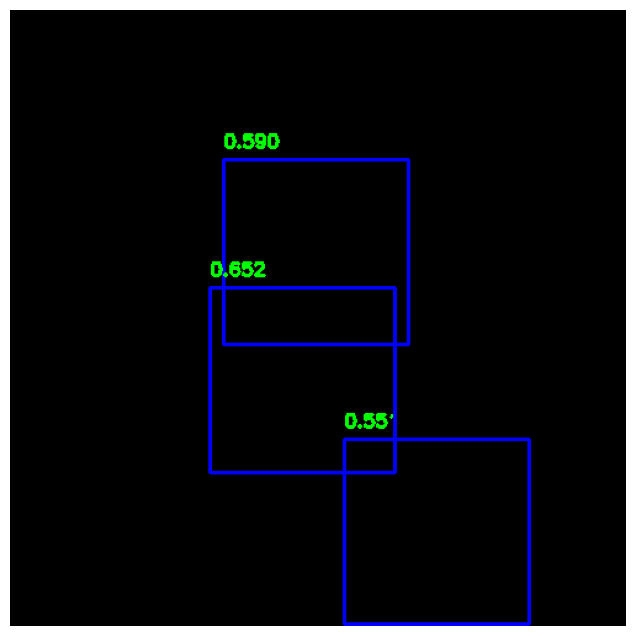

In [ ]:
bounding_boxes, confidence_score = compute_bounding_boxes(3, [150,150])
drawing_bounding_boxes(bounding_boxes,confidence_score)

In [ ]:
iou_matrix = compute_IOU_matrix_4(bounding_boxes, confidence_score,5,3,1)
iou_matrix = iou_matrix / np.max(np.abs(iou_matrix))
pprint(iou_matrix)

array([[ 0.90769231, -0.00531971, -0.00419655],
       [-0.00484685,  0.84615385, -0.00414654],
       [-0.00490584, -0.00532869,  1.        ]])


In [ ]:
iou_matrix = compute_IOU_matrix_for_min(bounding_boxes, confidence_score,5,3,1)
iou_matrix = np.array(iou_matrix)

# iou_matrix = iou_matrix / np.max(np.abs(iou_matrix))  # Divide by max absolute value (5)
pprint(iou_matrix)

array([[-2.95      ,  1.        ,  1.49686577],
       [ 1.        , -2.75      ,  1.07566127],
       [ 1.49686577,  1.07566127, -3.25      ]])


[[162, 225, 312, 375], [173, 121, 323, 271], [271, 348, 421, 498]]


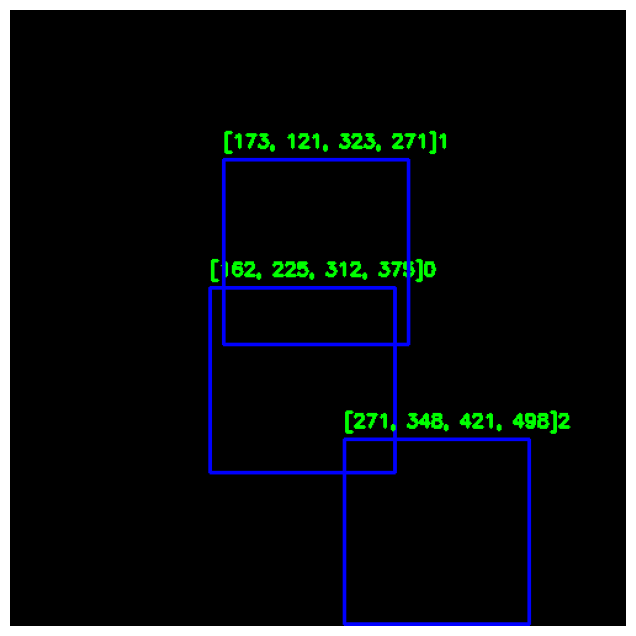

In [ ]:
indices = cv2.dnn.NMSBoxes(bounding_boxes, confidence_score, score_threshold=0.5, nms_threshold=0.4)
selected_boxes = [bounding_boxes[i] for i in indices.flatten()]
print(selected_boxes)
hel = len(selected_boxes)
# print(goo_boxes)
drawing_bounding_boxes(selected_boxes, selected_boxes[:hel])

In [ ]:
# iou_matrix = compute_IOU_matrix(goo_boxes,good_score)
print(iou_matrix)
QUBO_solution = {}

x = []
score = []

for i in (0,1):
    for j in (0,1):
        for k in (0,1):
            # for l in (0,1):
            #     for m in (0,1):
#                     for n in (0,1):
#                         res_matrix = [i,j,k,l,m]
                        res_matrix = [i,j,k]
                        res_matrix = np.array(res_matrix)
                        result = np.dot(iou_matrix,res_matrix)
                        result = np.dot(res_matrix.T, result)
                        x.append(res_matrix)
                        score.append(result)

for arr, score in zip(x, score):
    QUBO_solution.setdefault("results", []).append({"array": arr, "score": score})

pprint(QUBO_solution)

QUBO_solution['results'] = sorted(QUBO_solution['results'], key=lambda x:x["score"])
pprint(QUBO_solution)

[[-2.95        1.          1.49686577]
 [ 1.         -2.75        1.07566127]
 [ 1.49686577  1.07566127 -3.25      ]]
{'results': [{'array': array([0, 0, 0]), 'score': np.float64(0.0)},
             {'array': array([0, 0, 1]), 'score': np.float64(-3.25)},
             {'array': array([0, 1, 0]), 'score': np.float64(-2.75)},
             {'array': array([0, 1, 1]),
              'score': np.float64(-3.8486774656551157)},
             {'array': array([1, 0, 0]),
              'score': np.float64(-2.9499999999999997)},
             {'array': array([1, 0, 1]),
              'score': np.float64(-3.206268455680464)},
             {'array': array([1, 1, 0]),
              'score': np.float64(-3.6999999999999997)},
             {'array': array([1, 1, 1]),
              'score': np.float64(-1.8049459213355799)}]}
{'results': [{'array': array([0, 1, 1]),
              'score': np.float64(-3.8486774656551157)},
             {'array': array([1, 1, 0]),
              'score': np.float64(-3.69999999

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
import pennylane as qml
import numpy as np

NON MAXIMA SUPRESSION PROBLEM

$C = X^TQX$

Now to convert this problem into ising model we will take

$x_i = \frac{1-Z_i}{2}$

$C = \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} - \left( \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} \right) Z_i - \sum_{ij}\frac{Q_{ij}}{4}Z_j + \sum_{ij}\frac{Q_{ij}}{4}Z_iZ_j$

In [ ]:
I = [[1,0],[0,1]]
Z = [[1,0],[0,-1]]

# first_term = 0
# for i in range(len(iou_matrix)):
#     first_term = first_term + iou_matrix[i][i]/2

# second_term = 0
# for i in range(len(iou_matrix)):
#   for j in range(len(iou_matrix)):
#     if i!=j:
#       second_term = second_term + iou_matrix[i][j]/4

# const_matrix = (first_term+second_term)*(np.kron(I,np.kron(I,I)))

third_term = 0
for i in range(len(iou_matrix)):
    if i == 0:
      matrix = np.kron(Z,np.kron(I,I))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))
    if i == 1:
      matrix = np.kron(I,np.kron(Z,I))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))
    if i == 2:
      matrix = np.kron(I,np.kron(I,Z))
      third_term = third_term + (matrix*(iou_matrix[i][i]/2))

fourth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(Z,np.kron(I,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(Z,np.kron(I,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(Z,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(I,np.kron(Z,I))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(I,np.kron(I,Z))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(I,Z))
        fourth_term = fourth_term + (matrix*(iou_matrix[i][j]/4))

fifth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(I,np.kron(Z,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(I,np.kron(I,Z))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(I,Z))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(Z,np.kron(I,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(Z,np.kron(I,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(Z,I))
        fifth_term = fifth_term + (matrix*(iou_matrix[i][j]/4))

sixth_term = 0
for i in range(len(iou_matrix)):
  for j in range(len(iou_matrix)):
    if i!=j:
      if i == 0 and j == 1:
        matrix = np.kron(Z,np.kron(Z,I))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 0 and j == 2:
        matrix = np.kron(Z,np.kron(I,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 2:
        matrix = np.kron(I,np.kron(Z,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 1 and j == 0:
        matrix = np.kron(Z,np.kron(Z,I))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 0:
        matrix = np.kron(Z,np.kron(I,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))
      if i == 2 and j == 1:
        matrix = np.kron(I,np.kron(Z,Z))
        sixth_term = sixth_term + (matrix*(iou_matrix[i][j]/4))

result_matix = -third_term-fourth_term-fifth_term+sixth_term
print(result_matix)

[[ 2.68873648  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.56126352  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.06126352  0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -1.15994099  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.26126352  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.51753198
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -1.01126352  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.88379056]]


Now we compute this using quanthum circuit.

Quantum circuit mainly contains 3 gates. Z gate on a single qubit then ZZ gate which will be CNOT-Z-CNOT gate and X gate to all the qubits. Let us see how we can compute it.

In [ ]:
def construct_Z_term(q1,Q_matrix_entry,beta):
  qml.RZ(Q_matrix_entry*beta,wires=q1)

def construct_ZZ(q1,q2,Q_matrix_entry,gamma):
  qml.CNOT(wires=[q1,q2])
  qml.RZ(2*Q_matrix_entry*gamma,wires=q2)
  qml.CNOT(wires=[q1,q2])

def construct_mixer_x_gate(q1,beta):
  qml.RX(2*beta, wires=q1)

We want to construct

$C = \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} - \left( \sum_{i}\frac{Q_i}{2} + \sum_{ij}\frac{Q_{ij}}{4} \right) Z_i - \sum_{ij}\frac{Q_{ij}}{4}Z_j + \sum_{ij}\frac{Q_{ij}}{4}Z_iZ_j$

But problem is we don't know in which order we have to apply this gates. So as usual we will first go with the order which is given.

In [ ]:
def compute_cost_hamiltonian(Q_matrix, beta, gamma):
  dev = qml.device('default.qubit', wires = len(Q_matrix))
  @qml.qnode(dev)
  def cost_hamiltonian_circuit():
    for i in range(len(Q_matrix)):
      construct_Z_term(i, -Q_matrix[i][i]/2, gamma)
    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_Z_term(i, -Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_Z_term(j, -Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      for j in range(len(Q_matrix)):
        if i!=j:
          construct_ZZ(i,j,Q_matrix[i][j]/4, gamma)

    for i in range(len(Q_matrix)):
      construct_mixer_x_gate(i, beta)

    return qml.state()
  return cost_hamiltonian_circuit

qc = compute_cost_hamiltonian(iou_matrix, np.pi / 3, np.pi / 3)
print(qml.draw(qc)())

0: ──RZ(1.54)──RZ(-0.26)──RZ(-0.39)──RZ(-0.26)──RZ(-0.39)─╭●───────────╭●─╭●───────────╭●─╭X ···
1: ──RZ(1.44)──RZ(-0.26)──RZ(-0.28)──RZ(-0.26)──RZ(-0.28)─╰X──RZ(0.52)─╰X─│────────────│──╰● ···
2: ──RZ(1.70)──RZ(-0.39)──RZ(-0.28)──RZ(-0.39)──RZ(-0.28)─────────────────╰X──RZ(0.78)─╰X─── ···

0: ··· ──RZ(0.52)─╭X─────────────────╭X──RZ(0.78)─╭X──RX(2.09)────────────────────────┤  State
1: ··· ───────────╰●─╭●───────────╭●─│────────────│──╭X─────────RZ(0.56)─╭X──RX(2.09)─┤  State
2: ··· ──────────────╰X──RZ(0.56)─╰X─╰●───────────╰●─╰●──────────────────╰●──RX(2.09)─┤  State


The circuit shown above is one layer of cost hamiltonian followed by mixer hamiltonina. We want to compute it for P layers as per QAOA circuit.

In [ ]:
from collections import Counter

def compute_QAOA_circuit(Q_matrix, beta, gamma):
  assert(len(beta) == len(gamma))
  p = len(beta)
  dev = qml.device('default.qubit', wires = len(Q_matrix), shots=1000)
  @qml.qnode(dev)
  def QAOA_circuit():
    for i in range(len(Q_matrix)):
      qml.Hadamard(wires=i)
    for k in range(p):
      for i in range(len(Q_matrix)):
          construct_Z_term(i, -Q_matrix[i][i]/2, gamma[k])
      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_Z_term(i, -Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_Z_term(j, -Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        for j in range(len(Q_matrix)):
          if i!=j:
            construct_ZZ(i,j,Q_matrix[i][j]/4, gamma[k])

      for i in range(len(Q_matrix)):
        construct_mixer_x_gate(i, beta[k])
    return qml.counts()
  return QAOA_circuit()

qc = compute_QAOA_circuit(iou_matrix, [np.pi / 3], [np.pi / 3])
for key, value in qc.items():
    print(f"{key}: {value}")

000: 207
001: 160
010: 85
011: 37
100: 148
101: 2
110: 70
111: 291


In [ ]:
def NMS_objective(x,iou_matrix):
  detections = np.array([int(char) for char in x])
  result = np.dot(iou_matrix,detections)
  result = np.dot(detections.T, result)
  return result

NMS_objective('101',iou_matrix)

np.float64(-3.206268455680464)

In [ ]:
def compute_NMS_energy(counts,iou_matrix):
  energy = 0
  total_counts = 0
  for meas, meas_count in counts.items():
    obj_for_meas = NMS_objective(meas,iou_matrix)
    energy += obj_for_meas * meas_count
    total_counts += meas_count
  return energy/total_counts

compute_NMS_energy(qc, iou_matrix)

np.float64(-2.123402866249254)

In [ ]:
def get_black_box_objective(iou_matrix, p):
  def f(theta):
    beta = theta[:p]
    gamma = theta[p:]
    counts = compute_QAOA_circuit(iou_matrix, beta, gamma)
    # print(counts)
    return compute_NMS_energy(counts, iou_matrix)
  return f

In [ ]:
p = 10
obj = get_black_box_objective(iou_matrix,p)
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.91069872, 1.2067517 , 0.88762696, 1.87679759, 0.9234699, 2.9864091, 0.5627165, 3.91827365, 0.672536, 1.9283765, 0.6351722, 1.92837364, 0.982736, 3.9182736  ])
# init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.82730, 0.82736 ])

res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
res_sample

{np.str_('000'): np.int64(574), np.str_('010'): np.int64(35), np.str_('011'): np.int64(43), np.str_('100'): np.int64(36), np.str_('101'): np.int64(99), np.str_('110'): np.int64(79), np.str_('111'): np.int64(134)}
{np.str_('000'): np.int64(25), np.str_('001'): np.int64(45), np.str_('010'): np.int64(69), np.str_('011'): np.int64(323), np.str_('100'): np.int64(257), np.str_('101'): np.int64(151), np.str_('110'): np.int64(17), np.str_('111'): np.int64(113)}
{np.str_('000'): np.int64(138), np.str_('001'): np.int64(12), np.str_('010'): np.int64(8), np.str_('011'): np.int64(81), np.str_('100'): np.int64(23), np.str_('101'): np.int64(27), np.str_('110'): np.int64(296), np.str_('111'): np.int64(415)}
{np.str_('000'): np.int64(62), np.str_('001'): np.int64(45), np.str_('010'): np.int64(28), np.str_('011'): np.int64(180), np.str_('100'): np.int64(200), np.str_('101'): np.int64(127), np.str_('110'): np.int64(351), np.str_('111'): np.int64(7)}
{np.str_('000'): np.int64(16), np.str_('001'): np.int64

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.5811798048291124
       x: [ 1.945e+00  2.151e+00 ...  1.104e+00  3.805e+00]
    nfev: 187
   maxcv: 0.0

Below code computes random bounding box, and using NMS algorithm suppression takes place. Using same IOU and confidence score $H_C$ is computed to run on QAOA circuit. After optimization of QAOA macimum number of measurements shows final result using QAOA. You can see that detections using QAOA and NMS are some.

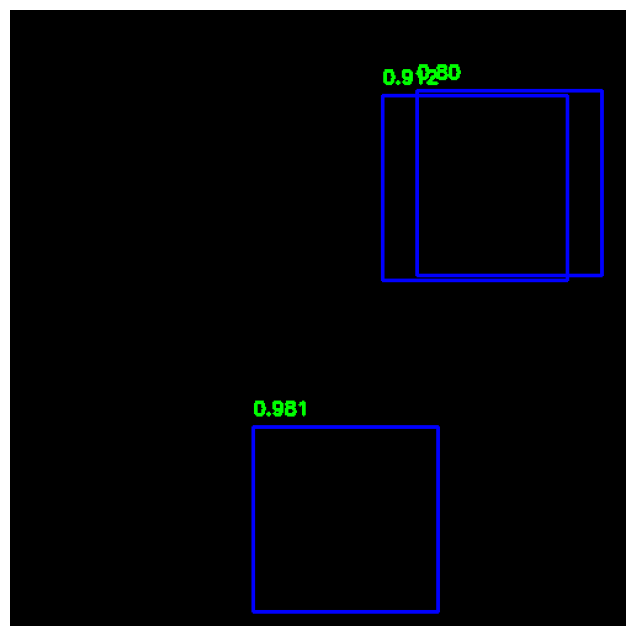

array([[-4.        ,  1.        ,  2.96542592],
       [ 1.        , -4.9       ,  1.        ],
       [ 2.96542592,  1.        , -4.55      ]])
[[197, 338, 347, 488], [302, 69, 452, 219]]


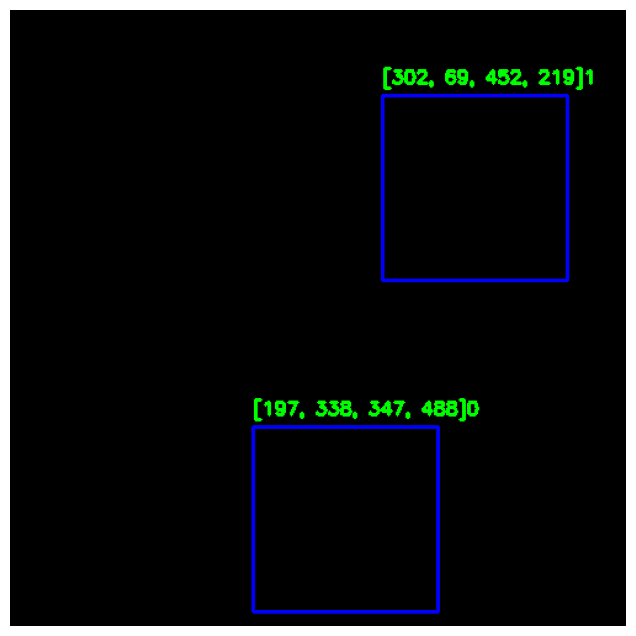

{np.str_('000'): np.int64(296), np.str_('001'): np.int64(108), np.str_('010'): np.int64(330), np.str_('011'): np.int64(64), np.str_('100'): np.int64(123), np.str_('101'): np.int64(61), np.str_('110'): np.int64(15), np.str_('111'): np.int64(3)}
{np.str_('000'): np.int64(136), np.str_('001'): np.int64(8), np.str_('010'): np.int64(393), np.str_('011'): np.int64(26), np.str_('100'): np.int64(130), np.str_('101'): np.int64(58), np.str_('110'): np.int64(100), np.str_('111'): np.int64(149)}
{np.str_('000'): np.int64(258), np.str_('001'): np.int64(25), np.str_('010'): np.int64(48), np.str_('011'): np.int64(225), np.str_('100'): np.int64(180), np.str_('101'): np.int64(20), np.str_('110'): np.int64(106), np.str_('111'): np.int64(138)}
{np.str_('000'): np.int64(75), np.str_('001'): np.int64(120), np.str_('010'): np.int64(43), np.str_('011'): np.int64(17), np.str_('100'): np.int64(364), np.str_('101'): np.int64(288), np.str_('110'): np.int64(59), np.str_('111'): np.int64(34)}
{np.str_('000'): np.i

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.081007444460791
       x: [ 1.735e+00  2.208e+00 ...  1.971e+00  3.818e+00]
    nfev: 200
   maxcv: 0.0

In [ ]:
bounding_boxes, confidence_score = compute_bounding_boxes(3, [150,150])
drawing_bounding_boxes(bounding_boxes,confidence_score)

iou_matrix = compute_IOU_matrix_for_min(bounding_boxes, confidence_score,5,3,1)
iou_matrix = np.array(iou_matrix)

# iou_matrix = iou_matrix / np.max(np.abs(iou_matrix))  # Divide by max absolute value (5)
pprint(iou_matrix)

indices = cv2.dnn.NMSBoxes(bounding_boxes, confidence_score, score_threshold=0.5, nms_threshold=0.4)
selected_boxes = [bounding_boxes[i] for i in indices.flatten()]
print(selected_boxes)
hel = len(selected_boxes)
# print(goo_boxes)
drawing_bounding_boxes(selected_boxes, selected_boxes[:hel])

p = 10
obj = get_black_box_objective(iou_matrix,p)
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.91069872, 1.2067517 , 0.88762696, 1.87679759, 0.9234699, 2.9864091, 0.5627165, 3.91827365, 0.672536, 1.9283765, 0.6351722, 1.92837364, 0.982736, 3.9182736  ])
# init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699, 2.42068091, 0.82730, 0.82736 ])

res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
res_sample

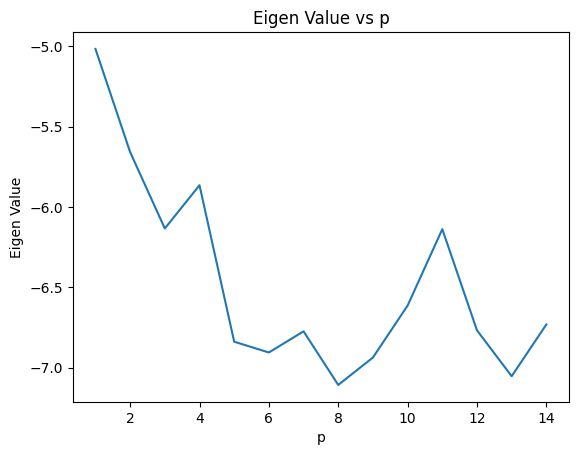

In [ ]:
p_size = []
eigen_value = []

for i in range(1,15):
  init_point = random_array = np.random.rand(2*i)
  p_size.append(i)

  obj = get_black_box_objective(iou_matrix,i)

  res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':5000, 'disp': True})
  eigen_value.append(res_sample.fun)

plt.plot(p_size, eigen_value)
plt.xlabel('p')
plt.ylabel('Eigen Value')
plt.title('Eigen Value vs p')
plt.show()
  # res_sample